<a href="https://colab.research.google.com/github/jacksontenorio8/Anti-Faude---Case-Solucion/blob/main/antifraude_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema Antifraude com Análise de Dados Transacionais

Este notebook segue o plano de análise para investigar fraudes em transações móveis e construir um sistema antifraude simples baseado em regras e/ou machine learning.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Visualização
sns.set(style='whitegrid')

## 1. Leitura dos dados

In [3]:
# Substitua pelo caminho do seu CSV
df = pd.read_csv('/content/drive/MyDrive/data/transactional-sample.csv')
df.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False


## 2. Pré-processamento dos dados

In [4]:
# Verificando nulos e tipos de dados
print(df.info())
print("\nNulos:\n", df.isnull().sum())

# Convertendo datas
if df['transaction_date'].dtype == 'object':
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      3199 non-null   int64  
 1   merchant_id         3199 non-null   int64  
 2   user_id             3199 non-null   int64  
 3   card_number         3199 non-null   object 
 4   transaction_date    3199 non-null   object 
 5   transaction_amount  3199 non-null   float64
 6   device_id           2369 non-null   float64
 7   has_cbk             3199 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 178.2+ KB
None

Nulos:
 transaction_id          0
merchant_id             0
user_id                 0
card_number             0
transaction_date        0
transaction_amount      0
device_id             830
has_cbk                 0
dtype: int64


In [5]:
# Removendo duplicatas e dados inconsistentes
df = df.drop_duplicates()
df = df[df['transaction_amount'] > 0]

# Normalizando colunas de texto se necessário (ex: card_number)
df['card_number'] = df['card_number'].astype(str).str.replace(r'\D', '', regex=True)

## 3. Análise Exploratória

In [6]:
# Estatísticas gerais
print(df.describe())
print("\nTransações com estorno:", df['has_cbk'].sum())

       transaction_id   merchant_id       user_id  \
count    3.199000e+03   3199.000000   3199.000000   
mean     2.132200e+07  48771.128790  50891.077212   
min      2.132040e+07     16.000000      6.000000   
25%      2.132120e+07  23426.000000  24267.500000   
50%      2.132200e+07  48752.000000  52307.000000   
75%      2.132280e+07  73915.000000  76837.000000   
max      2.132360e+07  99799.000000  99974.000000   
std      9.236161e+02  29100.360839  29515.282827   

                    transaction_date  transaction_amount      device_id  
count                           3199         3199.000000    2369.000000  
mean   2019-11-22 12:47:02.242350336          767.812904  493924.859856  
min       2019-11-01 01:27:15.811098            1.220000       2.000000  
25%    2019-11-18 18:35:57.557812992          205.235000  259344.000000  
50%    2019-11-23 13:50:58.758107904          415.940000  495443.000000  
75%    2019-11-28 21:51:06.055557376          981.680000  733243.000000  
max 

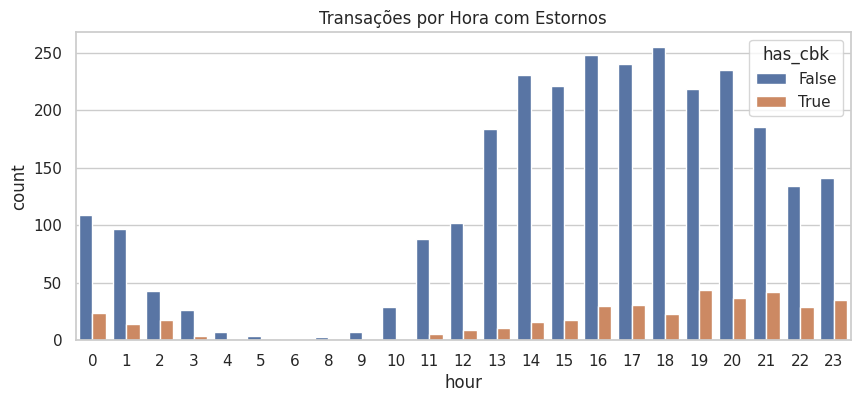

In [7]:
# Distribuição temporal
df['hour'] = df['transaction_date'].dt.hour
df['day'] = df['transaction_date'].dt.date

plt.figure(figsize=(10,4))
sns.countplot(x='hour', data=df, hue='has_cbk')
plt.title('Transações por Hora com Estornos')
plt.show()

## 4. Regras Antifraude Simples

In [8]:
# Sistema antifraude baseado em regras simples
def avaliar_transacao(transacao, historico):
    user_transacoes = historico[historico['user_id'] == transacao['user_id']]

    # Regra 1: Mais de 5 transações na última hora
    recentes = user_transacoes[user_transacoes['transaction_date'] > transacao['transaction_date'] - timedelta(hours=1)]
    if len(recentes) > 5:
        return "recusar"

    # Regra 2: Limite diário > R$5000
    dia = transacao['transaction_date'].date()
    total_dia = user_transacoes[user_transacoes['transaction_date'].dt.date == dia]['transaction_amount'].sum()
    if total_dia + transacao['transaction_amount'] > 5000:
        return "recusar"

    # Regra 3: Usuário com histórico de estorno
    if user_transacoes['has_cbk'].any():
        return "recusar"

    return "aprovar"

## 5. Simulação de avaliação de transações

In [9]:
# Exemplo: simular decisões
resultados = []

for i, row in df.iterrows():
    decisao = avaliar_transacao(row, df[df['transaction_date'] < row['transaction_date']])
    resultados.append(decisao)

df['recomendacao'] = resultados

# Comparando com estornos reais
df[['recomendacao', 'has_cbk']].value_counts(normalize=True)

,,proportion
recomendacao,has_cbk,
aprovar,False,0.865583
recusar,True,0.074398
aprovar,True,0.047827
recusar,False,0.012191


## 6. Conclusões e próximos passos

In [10]:
# Exemplo de recomendação de melhoria
print("Sugestão: adicionar geolocalização e device_info para melhorar o score de risco.")

Sugestão: adicionar geolocalização e device_info para melhorar o score de risco.
